<a href="https://colab.research.google.com/github/Jaehwi-So/DeepLearning_Study/blob/main/DL11_%08GAN_and_Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 시각화를 위한 코드

In [2]:
# 생성된 이미지 시각화
def gan_images(generator, epoch, noise_dim, rows=5, cols=5):
    noise = np.random.normal(0, 1, (rows * cols, noise_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = gen_imgs.reshape(rows * cols, 28, 28)

    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    cnt = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(gen_imgs[cnt], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# 결과 시각화
def plot_denoising_results(model, noisy_data, clean_data):
    decoded_imgs = model.predict(noisy_data)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy_data[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(clean_data[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')
    plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model

# 데이터 로드 및 전처리
MNIST 숫자 데이터를 사용하여 이를 기반으로 이미지를 생성해보자.

In [4]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data() # y를 사용하지 않음
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

# 3. GAN 모델 정의

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)

# 생성기 모델 정의
def build_generator():
    model = Sequential([
        # '''생성기 입력은 노이즈'''
        Dense(128, activation='relu', input_dim=100), #노이즈 크기 100
        # '''생성기 출력은 이미지 크기 만큼'''
        Dense(784, activation='sigmoid'),
        Reshape((28, 28, 1))  # 784차원 벡터를 28x28 이미지로 변환
    ])
    return model

# 판별기 모델 정의
def build_discriminator():
    model = Sequential([
        # 판별기 입력은 이미지
        layers.Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu', input_dim=784),
        # 판별기 출력은 출력이 1개
        Dense(1, activation='sigmoid')
    ])
    return model

# GAN 모델 구축 및 학습
def build_gan(generator, discriminator):
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    return gan

# 모델 생성
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# 하이퍼파라미터 설정
batch_size = 128
epochs = 10000
sample_interval = 1000
noise_dim = 100


# 모델 훈련

In [9]:
# 학습 과정
def train(generator, discriminator, gan, x_train, batch_size, epochs, noise_dim, sample_interval):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # 판별기 훈련
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_imgs = x_train[idx]

        noise = np.random.normal(0, 1, (half_batch, noise_dim))
        fake_imgs = generator.predict(noise)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        discriminator.train_on_batch(real_imgs, real_labels)
        discriminator.train_on_batch(fake_imgs, fake_labels)

        # 생성기 훈련
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        valid_y = np.ones((batch_size, 1))

        gan.train_on_batch(noise, valid_y)

        # 주기적으로 이미지 샘플링
        if epoch % sample_interval == 0:
            gan_images(generator, epoch, noise_dim)

### 모델 훈련 과정
- 생성기가 얼마나 점점 더 새로운 데이터를 잘 생성하는지 확인해보자.

1/1 [==============================] - 0s 73ms/step


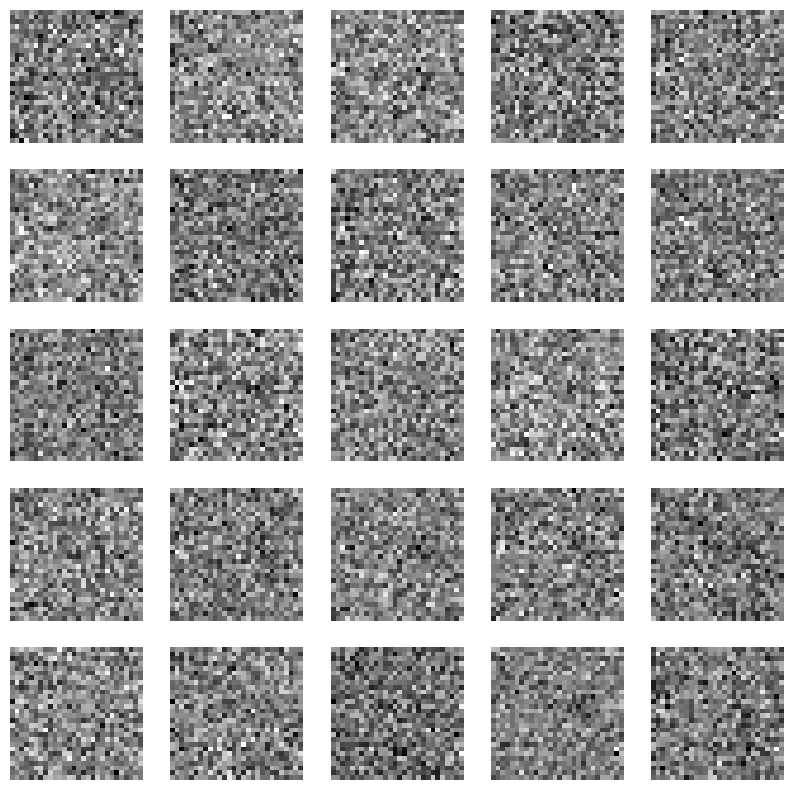

1/1 [==============================] - 0s 22ms/step


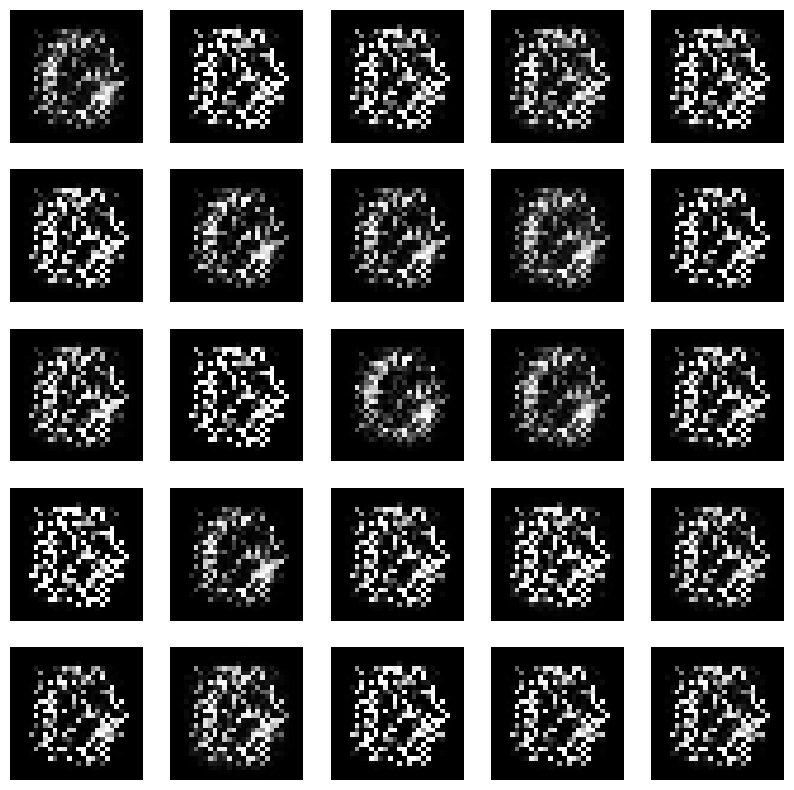

1/1 [==============================] - 0s 29ms/step


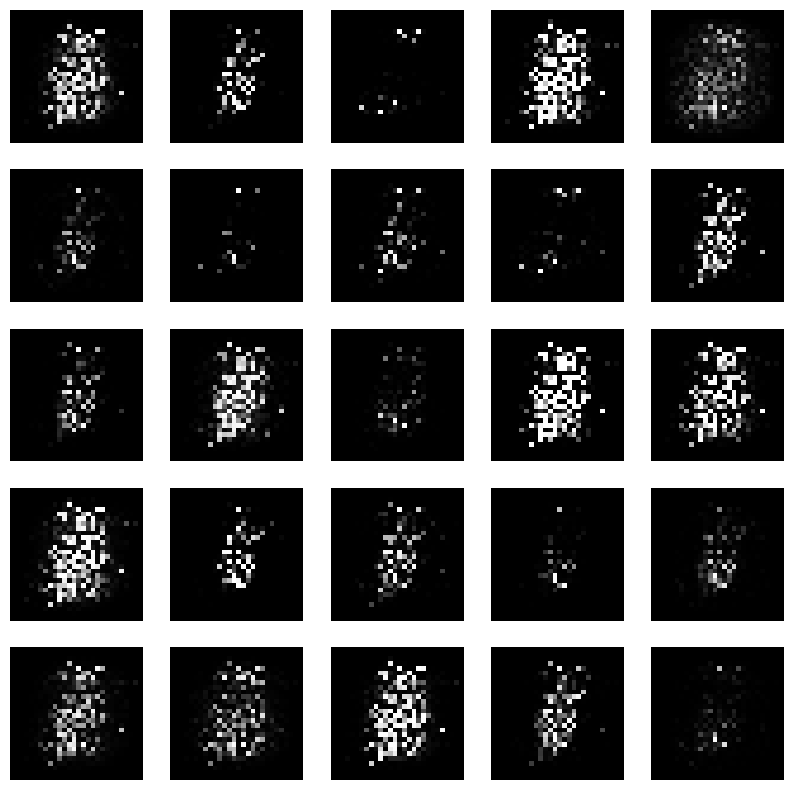

1/1 [==============================] - 0s 39ms/step


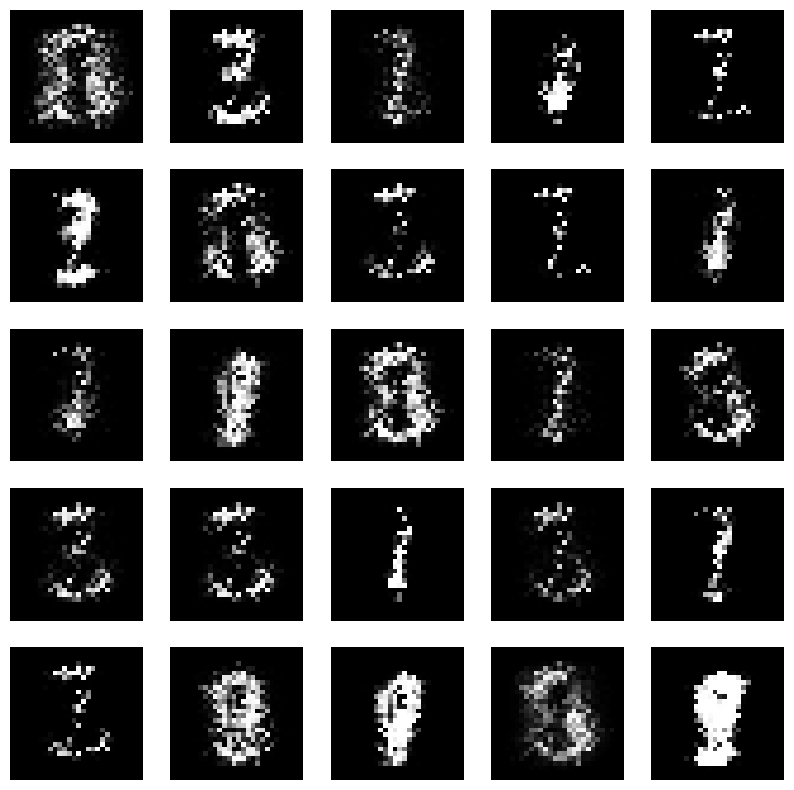

1/1 [==============================] - 0s 38ms/step


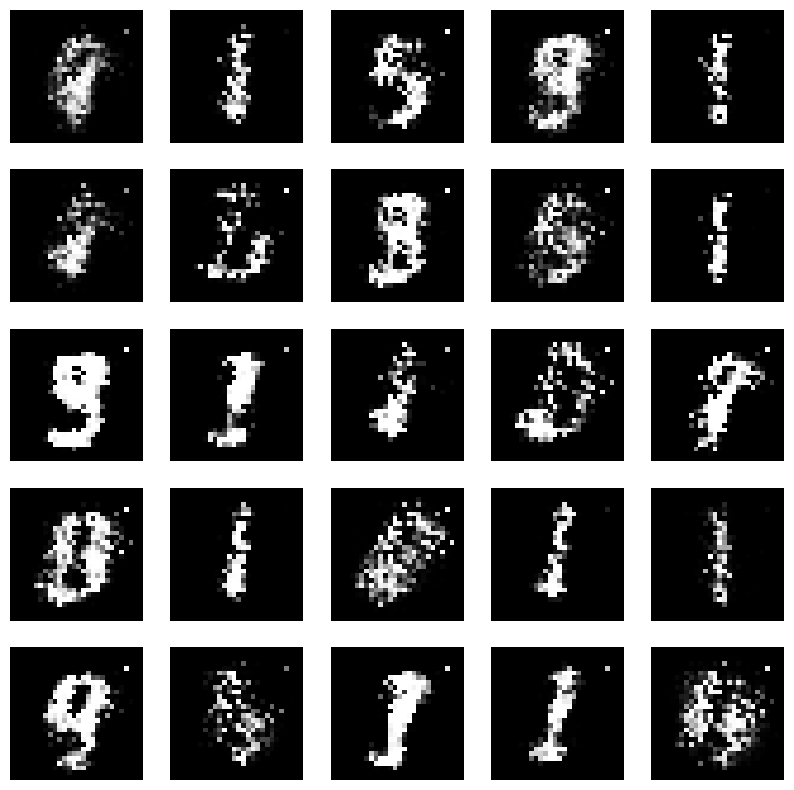

1/1 [==============================] - 0s 49ms/step


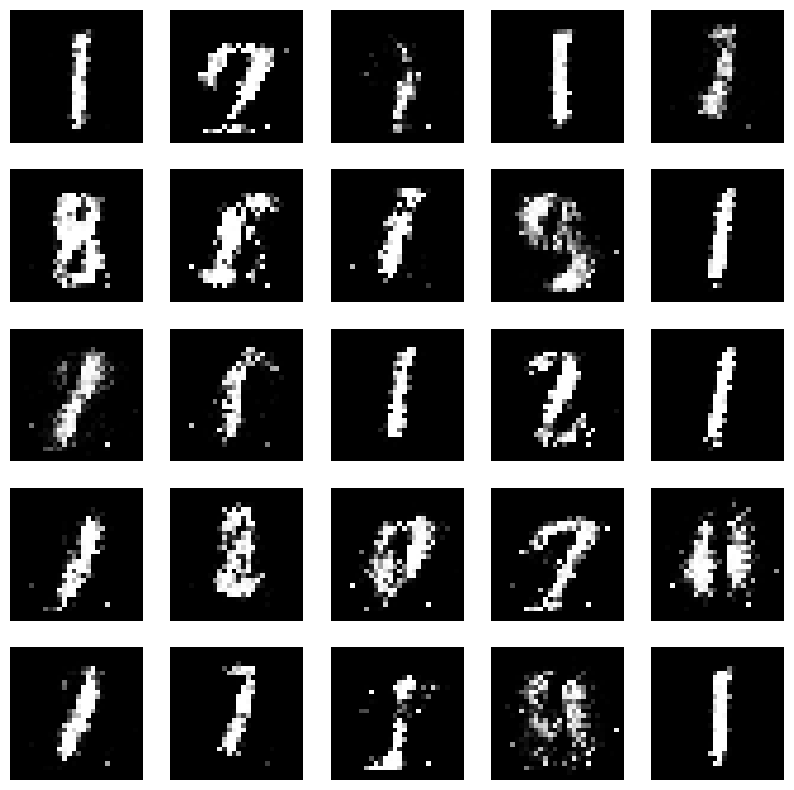

1/1 [==============================] - 0s 26ms/step


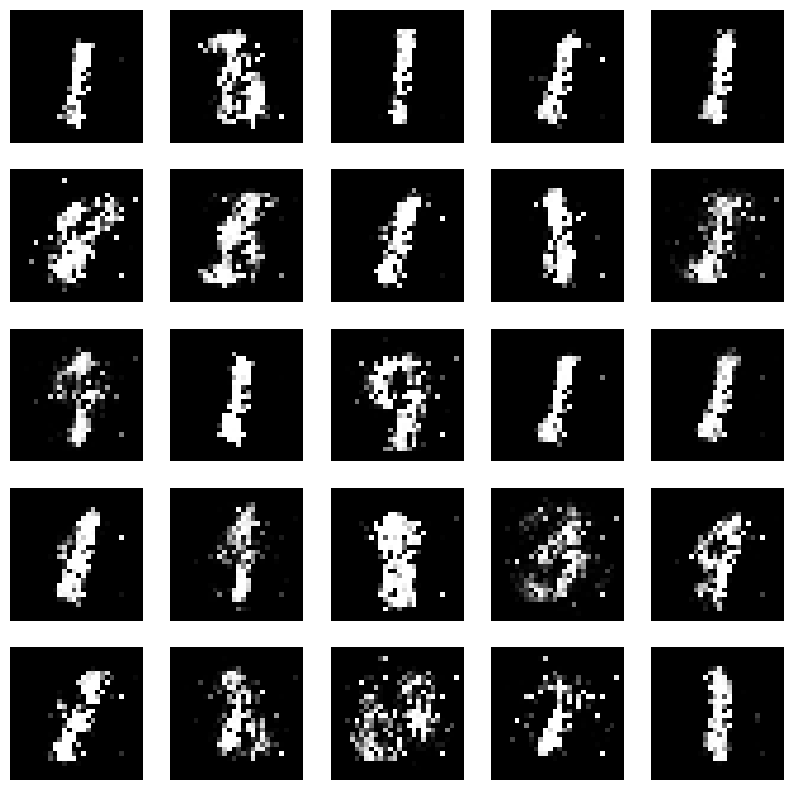

1/1 [==============================] - 0s 25ms/step


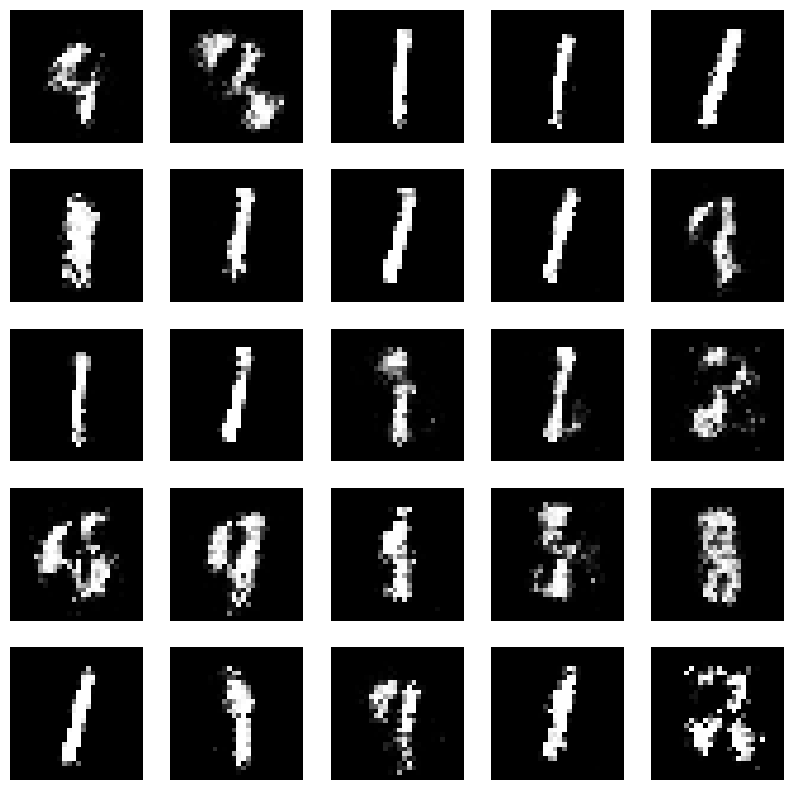

1/1 [==============================] - 0s 29ms/step


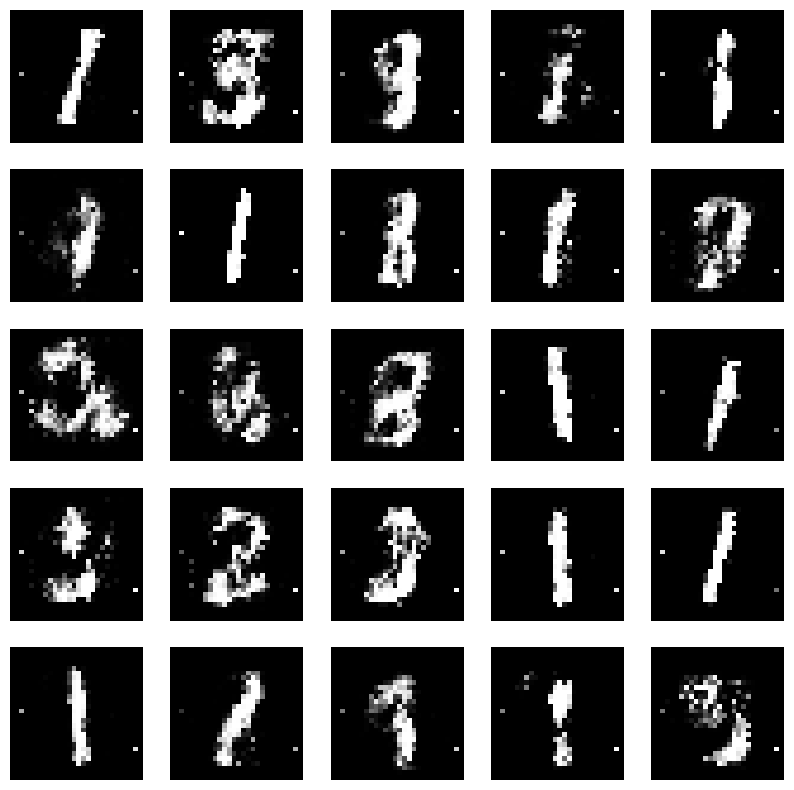

1/1 [==============================] - 0s 24ms/step


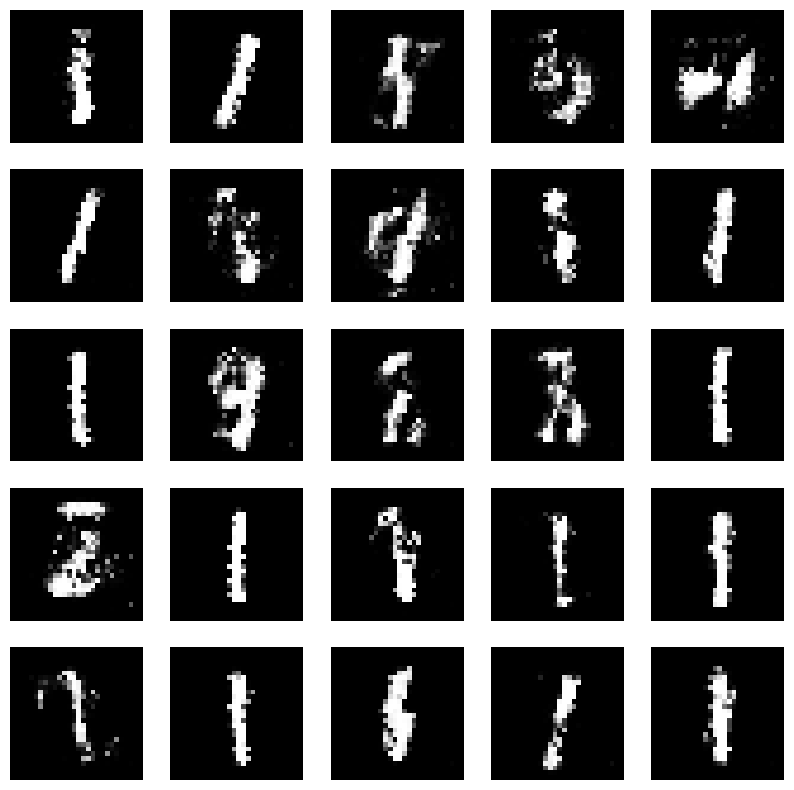

2/2 [==============================] - 0s 6ms/step


In [10]:
train(generator, discriminator, gan, x_train, batch_size, epochs, noise_dim, sample_interval)

# 4. Diffusion 모델 정의

In [11]:
# 노이즈 추가 함수
def add_noise(data, noise_factor=0.5):
    noisy_data = data + noise_factor * np.random.normal(size=data.shape)
    noisy_data = np.clip(noisy_data, 0., 1.)
    return noisy_data

# 노이즈 제거 모델 정의
def build_denoising_model():
    model = tf.keras.Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model


# 노이즈 데이터 생성
noise_factor = 0.5
x_train_noisy = add_noise(x_train, noise_factor) # '''학습 데이터 노이즈 입히기'''
x_test_noisy = add_noise(x_test, noise_factor) # '''테스트 데이터 노이즈 입히기'''

denoising_model = build_denoising_model()


### 모델 학습

In [12]:
# 모델 학습
denoising_model.fit(
    x_train_noisy, x_train, # 입력과 출력은 노이즈 추가된 입력, 노이즈 없는 출력
    epochs=10, batch_size=128,
    verbose=0,
    validation_data=(
        x_test_noisy, x_test
))

### 결과 확인 및 시각화

313/313 [==============================] - 5s 14ms/step


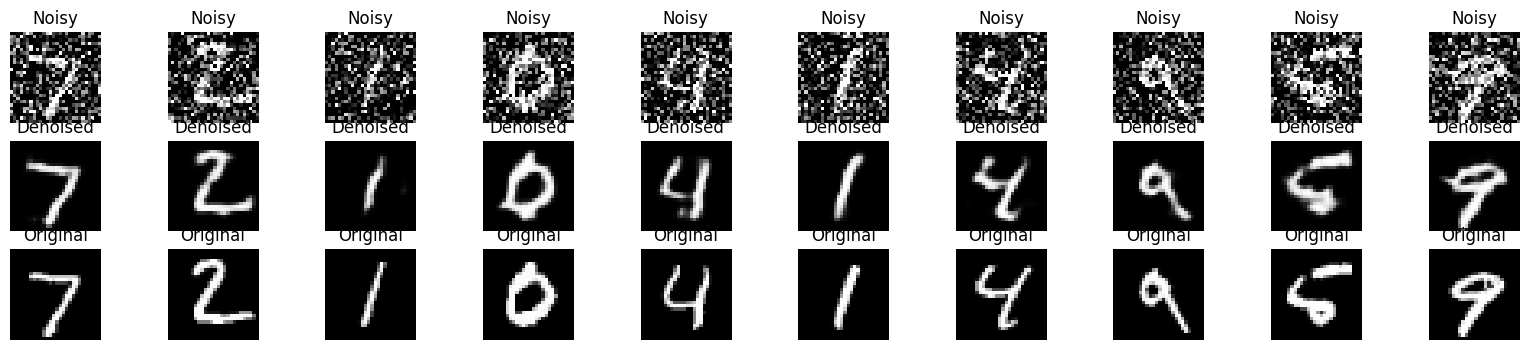

In [13]:
# 노이즈 제거 결과 시각화
plot_denoising_results(denoising_model, x_test_noisy, x_test)

# 학습된 Diffusion Model 사용
- 학습이 완료된 Diffusion Model을 사용해보자.

In [3]:
!pip install diffusers transformers scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.0 MB/s eta 0:00:00


In [4]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

# 모델 및 토크나이저 로드
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda" if torch.cuda.is_available() else "cpu"

pipeline = StableDiffusionPipeline.from_pretrained(model_id)
pipeline = pipeline.to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in yo

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

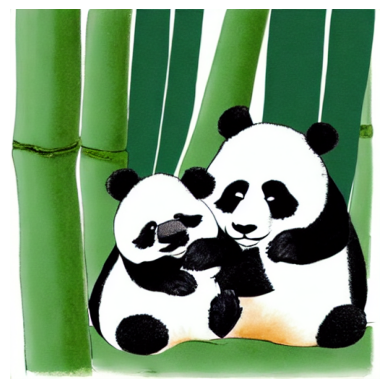

In [8]:
# 텍스트 프롬프트를 사용하여 이미지 생성
prompt = "bamboo and panda"
with torch.autocast("cuda"):
    image = pipeline(prompt)[0]

# 이미지 시각화
plt.imshow(image[0])
plt.axis("off")
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

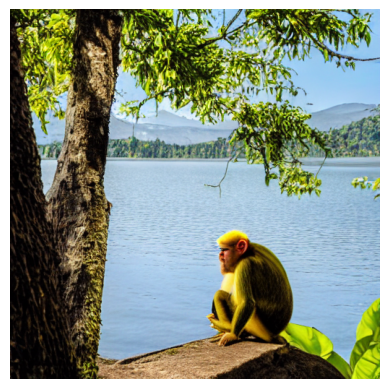

In [9]:
prompt = "yellow monkey and lake"
with torch.autocast("cuda"):
    image = pipeline(prompt)[0]

# 이미지 시각화
plt.imshow(image[0])
plt.axis("off")
plt.show()